In [7]:
from math import cos, log10, sin
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def binarySearch(x, arr):
        mid = len(arr) // 2
        low = 0
        high = len(arr) - 1

        while arr[mid] != x and low <= high:
            if x > arr[mid]:
                low = mid + 1
            else:
                high = mid - 1
            mid = (low + high) // 2

        return mid

class vide_solver:
    #RK_method_params
    # RK_param_e = [1/2, 1/2, 1]
    # RK_param_c = [0, 1/2, 1/2, 1]
    # RK_param_b = [1/6, 1/3, 1/3, 1/6]
    # RK_param_a = [[], [1/2], [0, 1/2], [0, 0, 1]]

    def __init__(self, K, f, limit=lambda x:0):
        self.K = K
        self.f = f
        self.low_integr_limit=limit


    def integration_K(self, t, X, Y, F):
        res = 0
        start = binarySearch(self.low_integr_limit(t), X)
        end = binarySearch(t, X)
        if start<0:
            if end<0:
                return (t-self.low_integr_limit(t))*Y[0]
            res+=(X[0]-self.low_integr_limit(t))*Y[0]
            start+=1
        elif self.low_integr_limit(t)!=X[start]:
            a = self.low_integr_limit(t)
            b = X[start + 1]
            h = b - a
            y_new=self.new_y(F[start], Y[start], h, (a-X[start])/(X[start+1]-X[start]))
            K_a = self.K(x=t, s=a, y=y_new)
            K_b = self.K(x=t, s=b, y=Y[start + 1])
            y_half_h = self.new_y(F[start], Y[start], h, (a+h/2-X[start])/(X[start+1]-X[start]))
            K_half_h = self.K(x=t, s=(a+b)/2, y=y_half_h)
            res += h/6*(K_a+4*K_half_h+K_b)
            start+=1
        

        for i in range(start, end):
            a = X[i]
            b = X[i + 1]
            h = b - a
            K_a = self.K(x=t, s=a, y=Y[i])
            K_b = self.K(x=t, s=b, y=Y[i + 1])
            y_half_h = self.new_y(F[i], Y[i], h, 1/2)
            K_half_h = self.K(x=t, s=(a+b)/2, y=y_half_h)
            res += h/6*(K_a+4*K_half_h+K_b)
        return res

    
    def b_param (self, teta):
        teta_2=teta*teta
        teta_3=teta_2*teta
        return [teta-3/2*teta_2+2/3*teta_3, teta_2-2/3*teta_3, teta_2-2/3*teta_3, 2/3*teta_3-teta_2/2]

    
    def Y_Z_f(self, h, X, Y, F_values):
        last_y=Y[-1]
        last_t=X[-1]
        step_const_x = last_t +1/2 * h
        F1=self.integration_K(last_t, X, Y, F_values)
        F=self.integration_K(step_const_x, X, Y, F_values)
        Y1 = last_y
        Z1=0
        f2=self.f(x=last_t, y=Y1, F_=F1+Z1)
        Y2=last_y+1/2*h*f2
        Z2=1/2*h*self.K(x=step_const_x, s=last_t, y=Y1)
        f3=self.f(x=step_const_x, y=Y2, F_=F+Z2)
        Y3=last_y+1/2*h*f3
        Z3=1/2*h*self.K(x=step_const_x, s=step_const_x, y=Y2)
        f4=self.f(x=step_const_x, y=Y3, F_=F+Z3)
        Y4=last_y+h*f4
        Z4=h*self.K(x=last_t +h, s=step_const_x, y=Y3)
        f_=[f2, 
            f3, 
            f4, 
            self.f(x=last_t+h, y=Y4, F_=self.integration_K(last_t+h, X, Y, F_values)+Z4)]
        return(f_)
    
    def new_y(self, f_, last_y, h, teta):
        RK_param_b=self.b_param(teta)
        return last_y+h*sum([f_[i]*RK_param_b[i] for i in range(4)])
    
    def RK_method(self, x0, x1, h, y0):
        X=[]
        Y=[]
        F=[]
        if isinstance(x0, list) and isinstance(y0, list):
            X.extend(x0)
            Y.extend(y0)
        else:  
            X.append(x0)
            Y.append(y0)
        while X[-1]+h<=x1:
            F.append(self.Y_Z_f(h, X, Y, F))
            Y.append(self.new_y(F[-1], Y[-1], h, 1))
            X.append(X[-1]+h)
        if X[-1]!=x1:
            F.append(self.Y_Z_f(x1-X[-1], X, Y, F))
            Y.append(self.new_y(F[-1], Y[-1], h, 1))
            X.append(x1)
        return(X,Y, F)
    
    
    def DiffrentsSteps(self, t, x0, y0):
        y_res=[]
        integ_res=[]
        H=[]
        for i in range(1, 9):
            h=1/(2**i)
            X,Y,F=self.RK_method(x0, t, h, y0)
            y_res.append(Y[-1])
            integ_res.append(self.integration_K(t, X, Y, F))
            H.append(log10(h))
        return(H, y_res, integ_res)
    
    def GraphConvDrow(self, estimated_convergence, H, Error):
        y = [Error[0] + estimated_convergence*(i-H[0]) for i in H]
        fig, ax = plt.subplots()
        ax.plot(H, Error, color='b', linestyle='--')
        ax.plot(H, y, 'r')
        plt.xlabel("log10(Длина шага)")
        plt.ylabel("log10(Норма полной погрешности)")
    
    def ConvCheck(self, estimated_convergence, solution_func, t, x0, y0):
        H_y_integration_res=self.DiffrentsSteps(t, x0, y0)
        true_sol_y_integ=[i(t) for i in solution_func]
        for i in range(len(solution_func)):
            error=[log10(abs(true_sol_y_integ[i]-j)) for j in H_y_integration_res[i+1]]
            self.GraphConvDrow(estimated_convergence, H_y_integration_res[0], error)

    def GraphSolution(self, t, x0, y0, h, analytical_solution=0):
        X,Y,F=self.RK_method(x0, t, h, y0)
        fig, ax = plt.subplots()
        if callable(analytical_solution):
            y = [analytical_solution(i) for i in X]
            ax.plot(X, y, 'r')
        ax.plot(X, Y, color='b', linestyle='--')
        plt.xlabel("x")
        plt.ylabel("y")
        return X,Y


In [9]:
print(binarySearch(1.5, [1,2,3]))

0


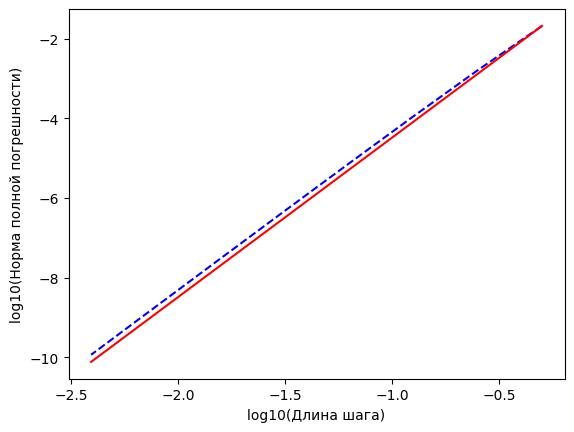

In [10]:
x0=0
y0=1
def K(x, s, y):
    return(1)

def f(x, y, F_):
    return(y)

def analytical_eq_solution(x):
    if x>=0:
        return(np.exp(x))
    return('error')

example0=vide_solver(K,f)
example0.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)

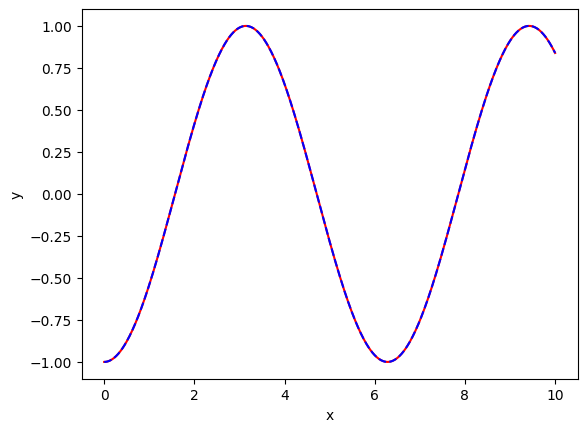

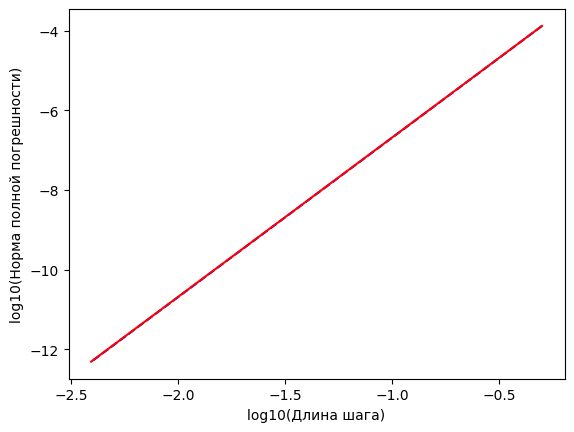

In [11]:
x0=0
y0=-1
def analytical_eq_solution(x):
    if x>=0:
        return(-cos(x))
    return('error')

def K(x, s, y):
    return(cos(s))

def f(x, y, F_):
    return(F_)

def analytical_integration_solution(end):
    def sol(s):
        return sin(s)
    return (sol(end)-sol(example1.low_integr_limit))

example1=vide_solver(K, f)
example1.GraphSolution(10, 0, -1, 1/2**6,analytical_eq_solution)



example1.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)
print()

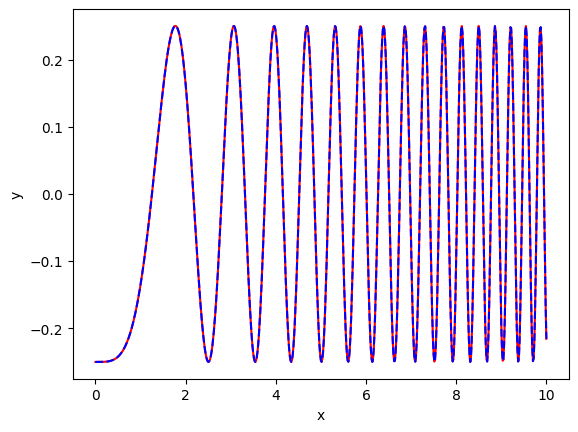

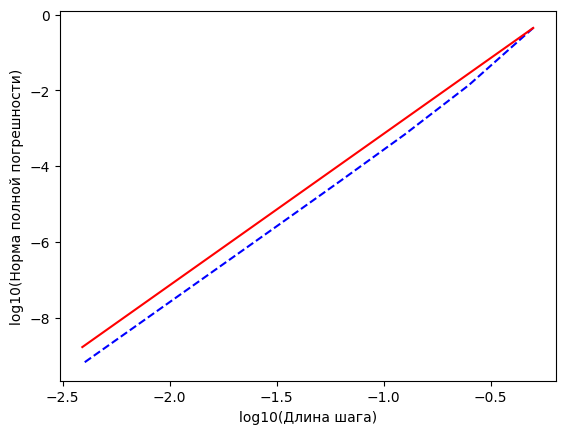

In [12]:
x0=0
y0=-1/4
def analytical_eq_solution(x):
    if x>=0:
        return(-1/4*cos(x*x))
    return('error')

def K(x, s, y):
    return(s*cos(s*s))

def f(x, y, F_):
    return(x*F_)

example2=vide_solver(K, f)
example2.GraphSolution(10, 0, -1/4, 1/2**6,analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return sin(s*s)/2
    return (sol(end)-sol(example2.low_integr_limit))

example2.ConvCheck(4, [analytical_eq_solution], 5, x0, y0)
print()

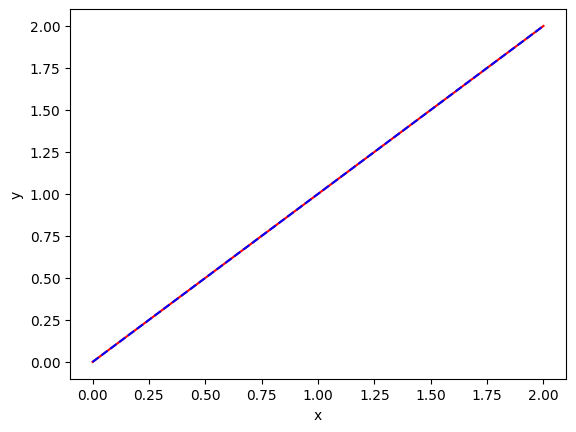

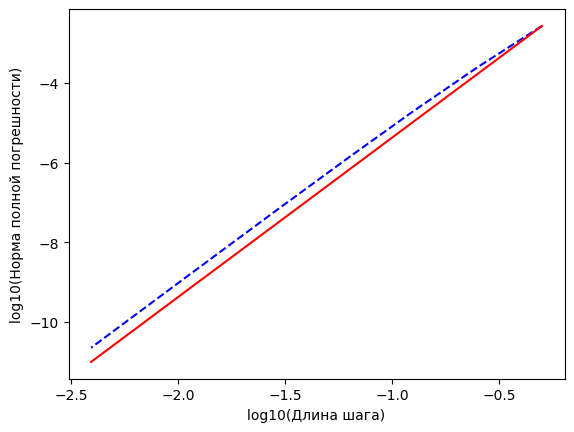

In [13]:
x0=0
y0=0
def analytical_eq_solution(x):
    if x>=0:
        return(x)
    return('error')

def K(x, s, y):
    return(s*np.exp(-(y**2)))

def f(x, y, F_):
    return(1-x*np.exp(-x**2)+y-2*x*F_)

example3=vide_solver(K, f)
# example3.GraphMethodConv(10, 0, 0)
example3.GraphSolution(2, 0, 0, 1/2**5,analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return -np.exp(-s*s)/2
    return (sol(end)-sol(example3.low_integr_limit))

example3.ConvCheck(4, [analytical_eq_solution], 2, x0, y0)
print()

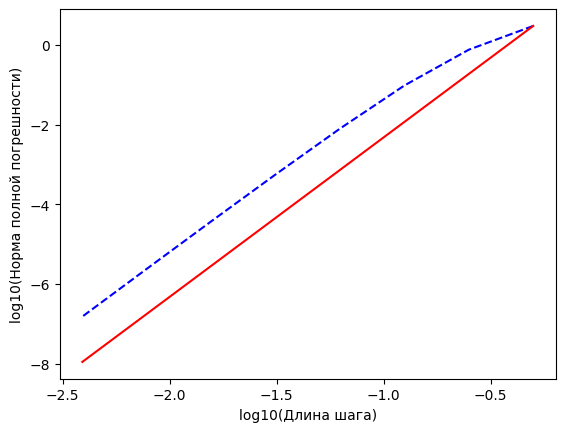

In [14]:
x0=0
y0=0
def analytical_eq_solution(x):
    if x>=0:
        return(x**2)
    return('error')

def K(x, s, y):
    return(s*np.exp(y))

def f(x, y, F_):
    return(5/2*x-1/2*x*np.exp(x**2)+x*F_)

example4=vide_solver(K, f)
# example4.GraphSolution(2, x0, y0, 1/2**6,analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return np.exp(s*s)/2
    return (sol(end)-sol(example4.low_integr_limit))

example4.ConvCheck(4, [analytical_eq_solution], 2, x0, y0)
print()

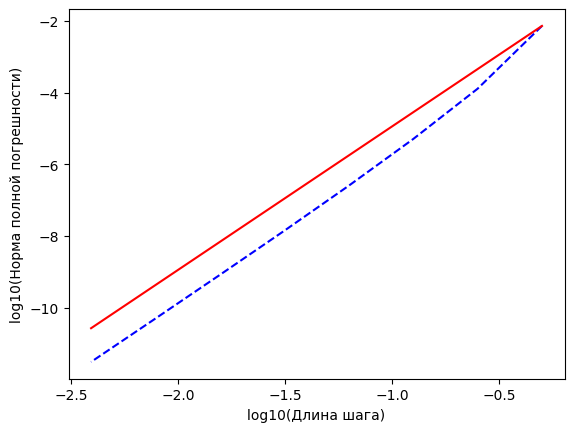

In [15]:
x0=0
y0=1
def analytical_eq_solution(x):
    if x>=0:
        return(1/(1+x))
    return('error')

def K(x, s, y):
    return(1/(1+(1+x)*y))

def f(x, y, F_):
    return(-x-1/((1+x)**2)+1/y *np.log((1+x)/(1+x/2))+F_)

example5=vide_solver(K, f)
# example5.GraphSolution(5, x0, y0, 1/2**6,analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return s-(end+1)*np.log(s+end+2)
    return (sol(end)-sol(example5.low_integr_limit))

example5.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)
print()

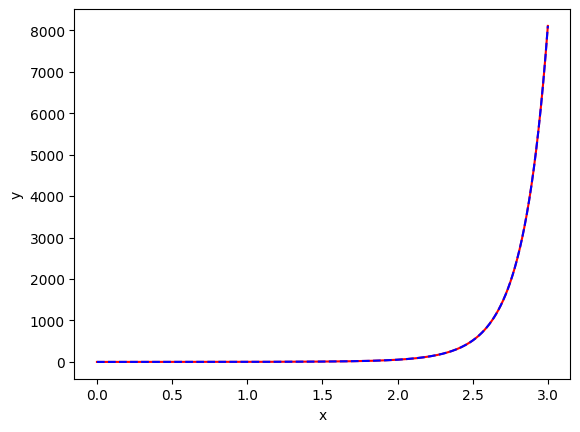

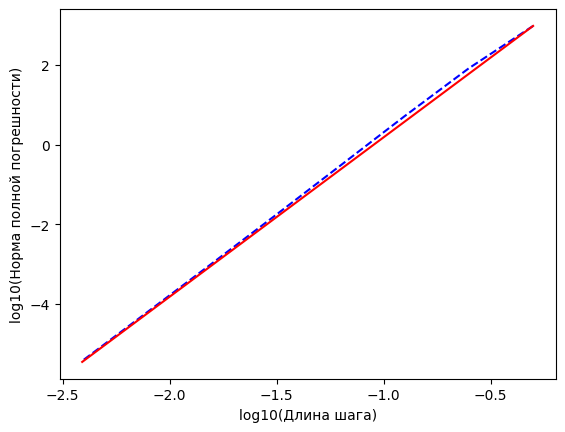

In [16]:
x0=0
y0=1
def analytical_eq_solution(x):
    if x>=0:
        return(np.exp(x**2))
    return('error')

def K(x, s, y):
    return(np.exp(s*x-s**2)*y)

def f(x, y, F_):
    return(1+2*x-y+x*(1+2*x)*F_)

example6=vide_solver(K, f)
example6.GraphSolution(3, x0, y0, 1/2**6,analytical_eq_solution)

def analytical_integration_solution(end):
    def sol(s):
        return np.exp(s*end)/end
    return (sol(end)-sol(example6.low_integr_limit))

example6.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)
print()

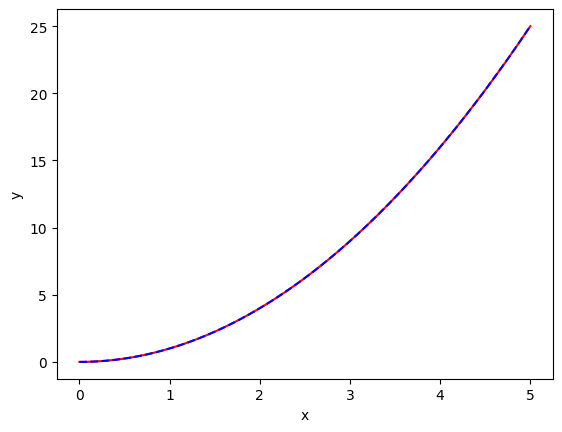

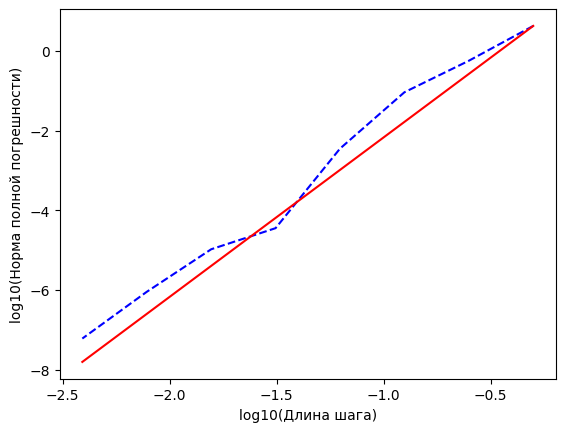

In [17]:
x0=0
y0=0
def analytical_eq_solution(x):
    if x>=0:
        return(x**2)
    return('error')

def K(x, s, y):
    return(s*cos(x*x*y))

def f(x, y, F_):
    return(2*x-1/2*sin(x**4)+x*x*F_)

example7=vide_solver( K, f)
example7.GraphSolution(5, x0, y0, 1/2**6,analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return sin(s*s*end*end)/(end*end*2)
    return (sol(end)-sol(example7.low_integr_limit))

example7.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)
print()

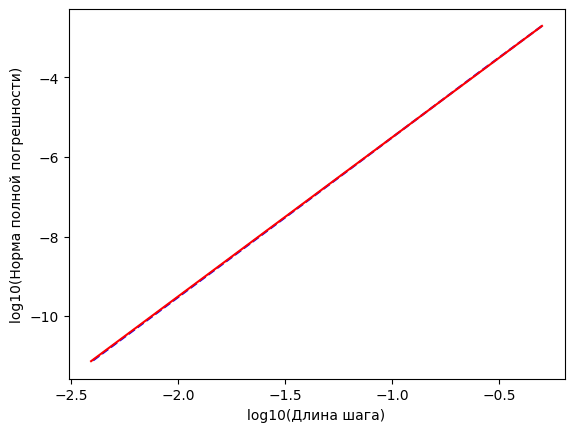

In [18]:
x0=0
y0=1
def analytical_eq_solution(x):
    if x>=0:
        return((1+x)*np.exp(-x))
    return('error')

def K(x, s, y):
    return(1/(1+s)*y)

def f(x, y, F_):
    return(((1+x)*np.exp(-x)-y)*cos(x)-(1+2*x)*np.exp(-x)+(1+x)*(1-F_))

def analytical_integration_solution(start, end):
    def sol(s):
        return(-np.exp(-s))
    return sol(end)-sol(start)

example9=vide_solver(K, f)
# example9.GraphSolution(5, x0, y0, 1/2**6, analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return -np.exp(-s)
    return (sol(end)-sol(example9.low_integr_limit))

example9.ConvCheck(4, [analytical_eq_solution], 3, x0, y0)
print()

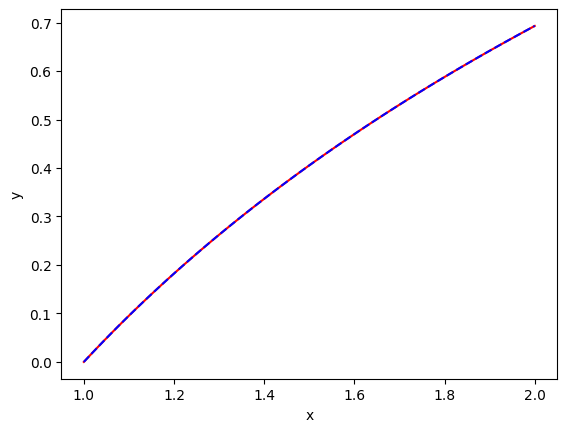

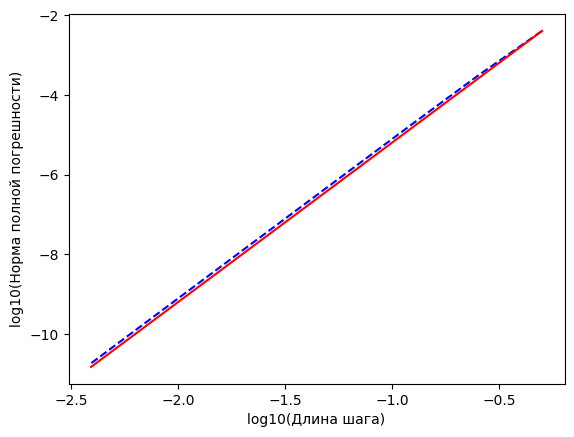

In [19]:
x0=1
y0=0
def analytical_eq_solution(x):
    if x>=1:
        return(np.log(x))
    return('error')

def K(x, s, y):
    return(s**2*np.exp(y))

def f(x, y, F_):
    return(-1/4*x**3+5/4*np.exp(-y)+1/x*F_)



example10=vide_solver(K, f, lambda x:1)
example10.GraphSolution(2, x0, y0, 1/2**6, analytical_eq_solution)
def analytical_integration_solution(end):
    def sol(s):
        return s**4/4
    return (sol(end)-sol(example10.low_integr_limit(end)))

example10.ConvCheck(4, [analytical_eq_solution], 2, x0, y0)
print()

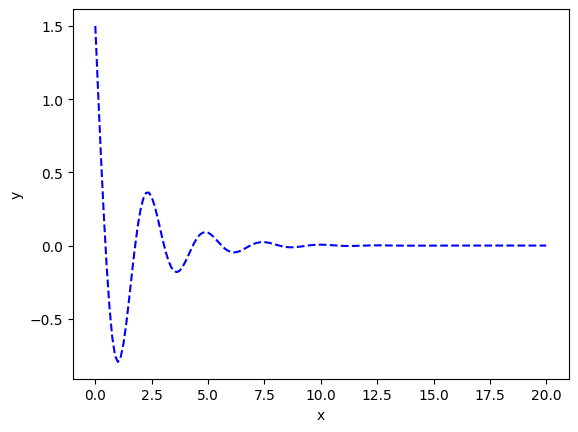

In [20]:
x0=0
y0=1.5


def K(x, s, y):
    return(sin(y))

def f(x, y, F_):
    return(-2.5*F_)



example11=vide_solver(K, f, lambda x:x-1)
example11.GraphSolution(20, x0, y0, 1/2**3)

print()

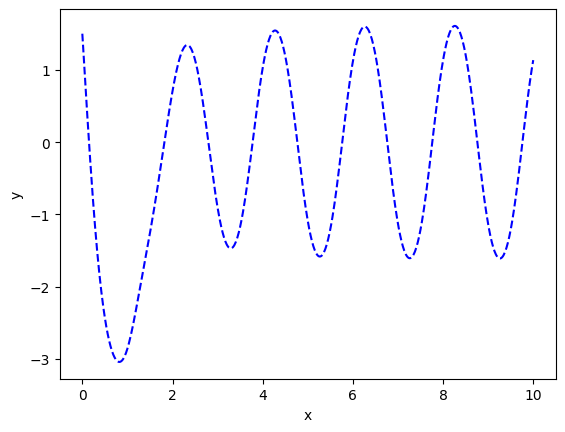

In [21]:
x0=0
y0=1.5


def K(x, s, y):
    return(sin(y))

def f(x, y, F_):
    return(-7*F_)



example12=vide_solver(K, f, lambda x:x-1)
example12.GraphSolution(10, x0, y0, 1/2**6)

print()

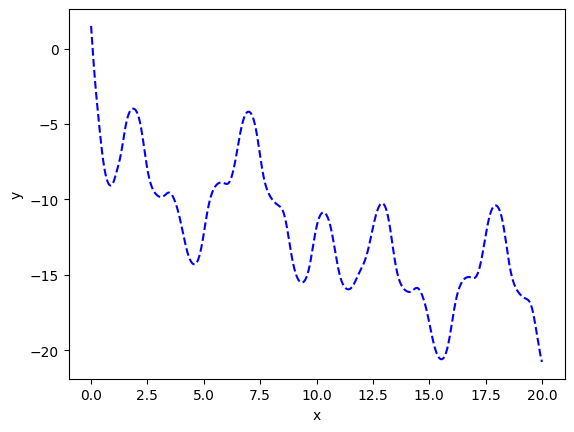

In [22]:
x0=0
y0=1.5


def K(x, s, y):
    return(sin(y))

def f(x, y, F_):
    return(-15*F_)



example13=vide_solver(K, f, lambda x:x-1)
example13.GraphSolution(20, x0, y0, 1/2**7)

print()